In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For some statistics
from scipy import stats
from scipy.stats import norm, skew

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("The train data size is : {} ".format(train.shape)) 
print("The test data size is : {} ".format(test.shape))

The train data size is : (1460, 80) 
The test data size is : (1459, 79) 


## Data Processing

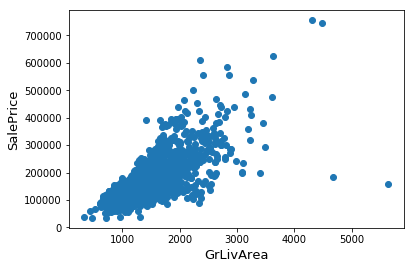

In [4]:
# Outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

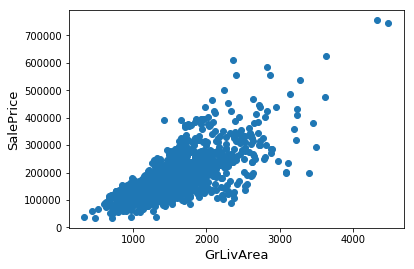

In [5]:
# We can see at the bottom right two with extremely large GrLivArea that are of a low price.
# These values are huge oultliers. Therefore, we can safely delete them.
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. You can refer to the modelling part of this notebook for that.

#### Analize target variable

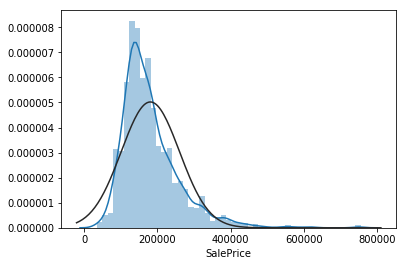

In [6]:
sns.distplot(train['SalePrice'] , fit=norm)

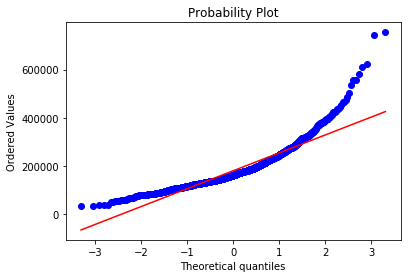

In [7]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

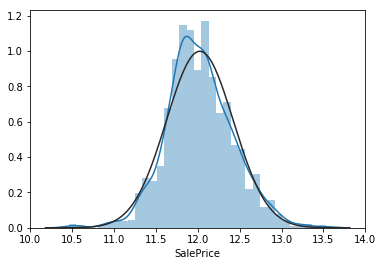

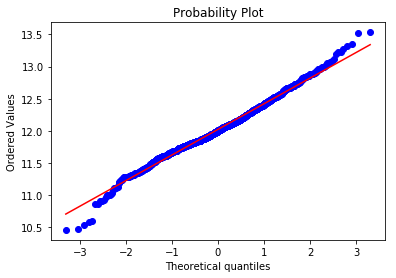

In [8]:
# Log-transformation of the target variable
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### Features engineering

In [9]:
# Concatenate both datasets to play with data at once
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


##### Missing data

In [10]:
data_na = (all_data.isnull().sum() / len(all_data)) * 100
data_na = data_na.sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageYrBlt,5.450806
GarageCond,5.450806


#### Fill NaN using also data description!
Make it column by column. If NaN from the documentation means no this feature in this house -> replace with None

In [11]:
# This categorical columns is likely equals None if no information
for col in ('PoolQC', 'Alley', 'Fence', 'MiscFeature', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
            'BsmtFinType2', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

In [12]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [13]:
# This numerical columns is likely equals 0 if no information
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea',
            'BsmtHalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'BsmtFinSF2',
            'TotalBsmtSF', 'BsmtFinSF1'):
    all_data[col] = all_data[col].fillna(0)

In [14]:
# This categorical columns with mode of values if no information
for col in ('MSZoning', 'Exterior1st', 'Exterior2nd', 
            'KitchenQual', 'SaleType', 'Electrical'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [15]:
# Discover Utilities
all_data.groupby('Utilities').count()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Utilities,,,,,,,,,,,,,,,,,,,,,
AllPub,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,...,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914
NoSeWa,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [16]:
all_data = all_data.drop('Utilities', axis=1)

In [17]:
# Discover Functional
all_data.groupby('Functional').count()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Functional,,,,,,,,,,,,,,,,,,,,,
Maj1,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
Maj2,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
Min1,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
Min2,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
Mod,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
Sev,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Typ,2715,2715,2715,2715,2715,2715,2715,2715,2715,2715,...,2715,2715,2715,2715,2715,2715,2715,2715,2715,2715


In [18]:
# Fill with Typical
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [19]:
data_na = (all_data.isnull().sum() / len(all_data)) * 100
data_na = data_na.sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(5)

,Missing Ratio
YrSold,0.0
Foundation,0.0
ExterCond,0.0
ExterQual,0.0
Exterior1st,0.0


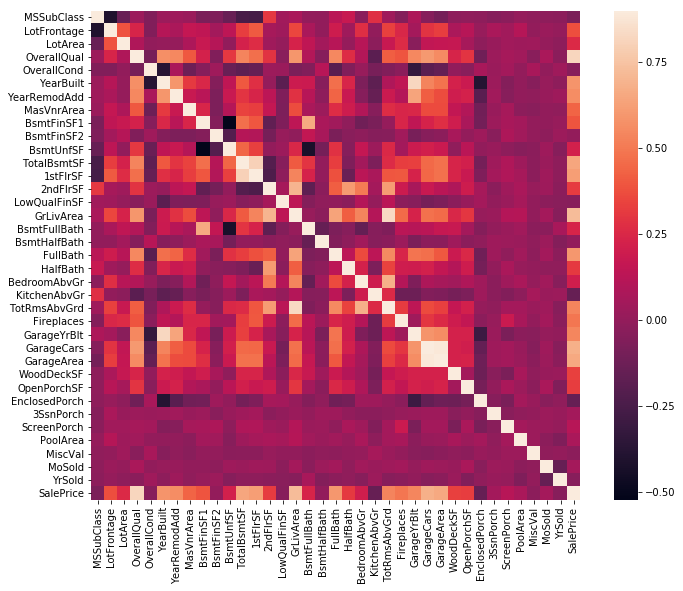

In [20]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### Some numerical variables is actually categorical, so change type to str

In [21]:
for col in ('MSSubClass', 'MoSold', 'YrSold'):
    all_data[col] = all_data[col].astype(str)

Apply label encoder to the features that are categorical but have some order

In [22]:
from sklearn.preprocessing import LabelEncoder
for col in ('LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'):
    encoder = LabelEncoder()
    all_data[col] = encoder.fit_transform(list(all_data[col].values))

In [23]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,4,3,706.0,0.0,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,4,1,978.0,0.0,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,4,2,486.0,0.0,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,1,3,216.0,0.0,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,4,0,655.0,0.0,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


### Need also play with skewed features, but add it later

In [24]:
# add dummies and split onto train and test sets
all_data = pd.get_dummies(all_data)

In [106]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Apply known regression models to get and measure predictions

In [107]:
# Separate on train test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y)

### Apply Scaling + PCA

In [108]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [109]:
# Measure accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f'Linaer regression MSE: {mean_squared_error(y_test, lr_pred)}')
print(f'Linaer regression MAE: {mean_absolute_error(y_test, lr_pred)}')

Linaer regression MSE: 651727.1507123903
Linaer regression MAE: 88.35440266175559


In [110]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [111]:
# Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print(accuracies.mean())
print(accuracies.std())

-1940.1795133
2920.25195302


#### SVM Regression

In [112]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

In [113]:
# Measure accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f'SVM regression MSE: {mean_squared_error(y_test, svr_pred)}')
print(f'SVM regression MAE: {mean_absolute_error(y_test, svr_pred)}')

SVM regression MSE: 0.16865214135597859
SVM regression MAE: 0.3110912274838721


In [114]:
# Cross Validation
accuracies = cross_val_score(svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print(accuracies.mean())
print(accuracies.std())

-0.310243363405
0.0174428672596


#### Random Forest

In [115]:
from sklearn.ensemble import RandomForestRegressor

In [116]:
rf = RandomForestRegressor(n_estimators=20)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [117]:
# Measure accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f'SVM regression MSE: {mean_squared_error(y_test,rf_pred)}')
print(f'SVM regression MAE: {mean_absolute_error(y_test, rf_pred)}')

SVM regression MSE: 0.02662498006275645
SVM regression MAE: 0.10775480885166577


In [118]:
# Cross Validation
accuracies = cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print(accuracies.mean())
print(accuracies.std())

-0.0995944772173
0.00931190669032


#### Use Grid Search

In [119]:
from sklearn.model_selection import GridSearchCV

In [120]:
parameters = [
    {'n_estimators': [10, 20, 30, 40, 50]}
]
grid = GridSearchCV(estimator=rf, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error',
                    cv=10, n_jobs=-1)
grid = grid.fit(X_train, y_train)

In [121]:
grid.best_params_

{'n_estimators': 40}

As I see the best result gives Random Forest regression model. SO use it to get predictions for the test data

In [122]:
rf_final = RandomForestRegressor(n_estimators=40)
rf_final.fit(train, y)
rf_test_pred = rf_final.predict(test)

In [123]:
price_pred = np.expm1(rf_test_pred)

In [124]:
price_pred

array([ 125920.51256687,  153315.51558709,  171648.77771254, ...,
        149905.14859985,  112262.33853355,  230561.08277208])

In [125]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = price_pred
sub.to_csv('submission.csv',index=False)

In [126]:
sub.head()

,Id,SalePrice
0,1461,125920.512567
1,1462,153315.515587
2,1463,171648.777713
3,1464,184266.043830
4,1465,211796.325821
